In [25]:
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [26]:
#-------------------------------------------------------
#                    (i-1,j)
#                       |
#                       |
#                       |
#                       |
# (i,j-i)-------------(i,j)------------- (i,j+1)
#                       |
#                       |
#                       |
#                       |
#                    (i+1,j)
#-------------------------------------------------------

### Grain growth:
* <b>Current layer</b> = layer currently being grown using kMC <br>
* <b>Previous layer</b> = input layer to which atoms on current layer are being bonded to

<br>

### Odd layers (starting layer 1): 
* Initial growth layer
* Matrix always starts with an atom at [0,0]
* If atom on this layer is trying to bond to an even layer below:
    * Atoms [i, j+1] or [i, j-1] must be present (left and right atoms on previous layer)

Ex, 
|  |  |  |  |  |  |
|---|---|---|---|---|---|
| 1 | 0 | 1 | 0 | 1 | 0 |
| 0 | 1 | 0 | 1 | 0 | 1 |
| 1 | 0 | 1 | 0 | 1 | 0 |
| 0 | 1 | 0 | 1 | 0 | 1 |
| 1 | 0 | 1 | 0 | 1 | 0 |
| 0 | 1 | 0 | 1 | 0 | 1 |

<br>

### Even layers (starting layer 2): 
* Matrix always starts with a vacancy at [0,0], first atom at [0, 1]
* If atom on this layer is trying to bond to an odd layer below:
    * Atoms [i+1, j] or [i-1, j] must be present (up and below atoms on previous layer)
    
Ex, 
|  |  |  |  |  |   |
|---|---|---|---|---|---|
| 0 | 1 | 0 | 1 | 0 | 1 |
| 1 | 0 | 1 | 0 | 1 | 0 |
| 0 | 1 | 0 | 1 | 0 | 1 |
| 1 | 0 | 1 | 0 | 1 | 0 |
| 0 | 1 | 0 | 1 | 0 | 1 |
| 1 | 0 | 1 | 0 | 1 | 0 |

<br>

### Growth Rate (GR) Equation

The equation for the growth rate (GR) in nm/min is:

$$
GR = \left( 8P + n_n^2 \frac{T - 273.15}{10} \right) \left( 2n_b^2 \times 10^6 \right) e^{\frac{-1.39 \, eV}{k_B T}}
$$

#### Definitions

- ${P}$: Partial Pressure of the gas in Pa (ex, 133 Pa = 1 torr)
- ${n_n}$: Number of neighbors in the current layer
- ${n_b}$: Number of bonds available 
- ${T}$: Temperature in Kelvin (ex, 500 C)
- ${k_B}$: Boltzmann constant in eV 

This means:
- If temperature constant: Scale <b>linearly</b> with partial pressure
- If Pressure constant: Scale <b>exponentially</b> with temperature
- If Neighbours are present: Scale <b>linearly</b> with temperature and <b>exponentially</b> with neighbours
- If Number of bonds present: Scale <b>exponentially</b> with scaling factor of 1 million




In [27]:
kb = 8.6173303 * (10E-5) # eV

def c_to_k(temp):
    return temp + 273.15

def growth_rate(P, nn, nb, T, kb):
    """
    Parameters:
    - P (float): Partial Pressure of the gas (Pa)
    - n_n (int): Number of neighbors in the current layer
    - n_b (int): Number of bonds available
    - T (float): Temperature (K)
    - k_B (float): Boltzmann constant in eV

    Returns:
    - float: growth rate in nm/second
    """

    # Calculate the pressure and temperature dependent linear portion
    linear = 8 * P + (nn ** 2) * ((T - 273.15) / 10 ** 1)

    # Calculate the exponential in the arrhenius equation with scaling factor
    exponential = 4 * nb ** 2  * np.exp(-(1.39) / (kb*T)) * 10 ** 6

    return (linear * exponential) / 60

In [28]:
def initialize_lattice(size, layer_number=1, percentage=1, seed=None):
    """
    Initialize a 2D lattice grid with the specified size and for a layer, where a given 
    percentage of sites are set to 1 (occupied) and the rest to 0 (unoccupied).
    
    Parameters:
    - size (int): The size of the lattice (NxN).
    - layer_number (int): The layer number a new lattice is being generated for.
    - percentage (float): Fraction of sites to initialize with a value of 1. Must be between 0 and 1.
    - seed (int or None): Seed for the random number generator for reproducibility. Default is None.
    
    Returns:
    - np.ndarray: Initialized lattice with specified occupancy.
    """
    if not (0 <= percentage <= 1):
        raise ValueError("Percentage must be between 0 and 1.")

    # Set random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
    
    # Create an NxN lattice filled with zeros
    lattice = np.zeros((size, size), dtype=int)
    
    # Randomly select indices to set to 1
    num_ones = int(size * size * percentage)
    ones_indices = np.random.choice(size * size, num_ones, replace=False)
    lattice.ravel()[ones_indices] = 1

    if layer_number % 2 == 1:
        # Odd layer, starts with an atom 
        #   -> Set every other entry to zero, starting at the second index
        lattice[::2, 1::2] = 0
        lattice[1::2, ::2] = 0
    else:
        # Even layer, starts with a vacancy
        #   -> Set every other entry to zero, starting at the first index
        lattice[::2, ::2] = 0
        lattice[1::2, 1::2] = 0
    
    return lattice

def get_array_of_sites(size, layer_number):
    """
    Generate an array of site indices for the lattice.
    
    The sites indices will be for every other index of the array (layer dependant)
    - Odd layer: sites start at [0, 0]
    - Even layer: sites start at [0, 1]

    Parameters:
    - size (int): The size of the lattice (NxN).
    - layer_number (int): The layer number a new lattice is being generated for.

    Returns:
    - list( tuple(int, int) ): Array of layer depedant site indices.
    """
    # Generate mask containing 1s at the sites
    layer_mask = initialize_lattice(size, layer_number)

    array_of_sites = []

    for i in range(size):
        for j in range(size):
            if layer_mask[(i, j)]:
                array_of_sites.append((i, j))
                
    return array_of_sites

In [29]:
def coordinates_neighbours_previous_layer(site_coordinate, length):
    '''
    Calculates coordinates of neighbouring atoms on the previous layer, in the form:
    [Top, Bottom, Right, Left]
    
    Parameters:
    - site_coordinates (tuple(int, int)): Coordinates of the site on the current layer.
    - length (int): The size of the lattice (NxN).

    Returns:
    - list( tuple(int, int) ): Array of coordinates for neighbours in the previous layer.
                                -> [Top, Bottom, Right, Left]
    '''
    # Determine the neighboring coordinates for a given site
    x, y = site_coordinate

    neighbours = [
        ((x + 1) % length, y),  # Top neighbor
        ((x - 1) % length, y),  # Bottom neighbor
        (x, (y + 1) % length),  # Right neighbor
        (x, (y - 1) % length)   # Left neighbor
    ]

    return neighbours

def coordinates_neighbours_current_layer(site_coordinate, length):
    '''
    Calculates coordinates of neighbouring atoms on the current layer, in the form:
    [NE, SE, SW, NW]

    Say the atom below (1) is the input site coordinate. The * represent the [NE, SE, SW, NW]
    this function is locating.
        N
      * 0 * 
    W 0 1 0 E
      * 0 *
        S

    Parameters:
    - site_coordinates (tuple(int, int)): Coordinates of the site on the current layer.
    - length (int): The size of the lattice (NxN).

    Returns:
    - list( tuple(int, int) ): Array of coordinates for neighbours in the current layer.
                                -> [NE, SE, SW, NW]
    '''
    # Determine the neighboring coordinates for a given site
    x, y = site_coordinate

    neighbours = [
        ((x - 1) % length, (y + 1) % length),  # NE neighbor
        ((x + 1) % length, (y + 1) % length),  # SE neighbor
        ((x + 1) % length, (y - 1) % length),  # SW neighbor
        ((x - 1) % length, (y - 1) % length)   # NW neighbor
    ]

    return neighbours

In [30]:
def get_number_neighbours_and_bonding(current_layer, layer_number, previous_layer, site_coordinate, length):
    '''
    Calculates the number of neighbours on the previous layer and current layer, and determines if bonding 
    is possible at the site coordinate.

    Parameters:
    - current_layer (np.array): Lattice layer (2D, NxN) that is current being grown.
    - layer_number (int): Layer number of current layer.
    - previous_layer (np.array): Lattice layer (2D, NxN) that atoms on current layer are being bonded to.
    - site_coordinates (tuple(int, int)): Coordinates of the site on the current layer.
    - length (int): The size of the lattice (NxN).

    Returns:
    - int, int, int: -> number_neighbours_previous_layer: for the given site coordinate
                      -> number_neighbours_current_layer: for the given site coordinate
                      -> bonding: int corresponding to the number of bonds available for that site
                                  -> 0 = No bonding
                                  -> 1 = 1 bond available
                                  -> 2 = 2 bonds available
    '''
    # Count the number of occupied neighbors for a given site for the current and previous layer
    number_neighbours_previous_layer = 0
    number_neighbours_current_layer = 0
    
    # Returns [Top, Bottom, Right, Left] coordinates
    neighbours_previous_layer = coordinates_neighbours_previous_layer(site_coordinate, length)
    
    # Returns [NE, SE, SW, NW]
    neighbours_current_layer = coordinates_neighbours_current_layer(site_coordinate, length) 

    # Get number of neighbours on previous layer
    for neighbour in neighbours_previous_layer:
        number_neighbours_previous_layer += previous_layer[neighbour]

    # Checking if bonding is legal on previous layer (growth direction is layer dependant)
    if layer_number % 2 == 1:
        # Odd layer: atoms to the left and right on previous layer must be present for bonding at site coordinate
        bonding = sum(
            [previous_layer[neighbours_previous_layer[2]], previous_layer[neighbours_previous_layer[3]]]
        )

    else:
        # Even layer: atoms to the top and bottom on previous layer must be present for bonding at site coordinate
        bonding = sum(
            [previous_layer[neighbours_previous_layer[0]], previous_layer[neighbours_previous_layer[1]]]
        )

    # Get number of neighbours on current layer
    for neighbour in neighbours_current_layer:
        number_neighbours_current_layer += current_layer[neighbour]

    return number_neighbours_previous_layer, number_neighbours_current_layer, bonding


In [31]:
def step_forward(current_time, current_layer, layer_number, previous_layer, array_of_sites, length, simulation_params=(133, 500)):
    """
    Perform a single time step in the simulation, where based on probabilities, an atom will bond to 
    the current layer.
    
    Parameters:
    - current_time (float): Current simulation time
    - current_layer (np.array): Lattice layer (2D, NxN) that is current being grown.
    - layer_number (int): Layer number of current layer.
    - previous_layer (np.array): Lattice layer (2D, NxN) that atoms on current layer are being bonded to.
    - array_of_sites (list( tuple(int, int) )): List of site indices in the lattice
    - length (int): The size of the lattice (NxN).
    - simulation_params (tuple): Tuple containing (partial_pressure in Pa, temperature in C)
    
    Returns:
    - np.array, float: Updated current_layer array and new time
    """
    partial_pressure, temperature = simulation_params # [s^-1]

    # convert temp to K
    temperature = c_to_k(temperature)

    # Calculate rates based on if bonding is possible, and neighbours in previous and current layers
    rates = np.zeros(len(array_of_sites))

    for site_index, site_coordinate in enumerate(array_of_sites):
        number_neighbours_previous_layer, number_neighbours_current_layer, bonding = get_number_neighbours_and_bonding(current_layer, layer_number, previous_layer, site_coordinate, length)

        # If site is unoccupied and bonding is possible
        if current_layer[site_coordinate] == 0 and bonding:
            rates[site_index] = growth_rate(partial_pressure, number_neighbours_current_layer, bonding, temperature, kb)
        else:
            rates[site_index] = 0

    # Calculate total rate
    total_rate = np.sum(rates)

    # Select a random site to update based on calculated rate if there are non zero probabilities
    if total_rate != 0:
        chosen_site_index = np.random.choice(len(array_of_sites), p=rates / total_rate)
        chosen_site = array_of_sites[chosen_site_index]

        # Atom bonded!
        current_layer[chosen_site] = 1

    # Randomly step time forward by exponential distribution
    current_time += np.random.exponential(1 / total_rate)
    return current_layer, current_time

In [32]:
def run_monolayer_simulation(current_layer, layer_number, previous_layer, length, n_steps=100, simulation_params=(133,500)):
    """
    Perform a simulation for monolayer growth, and save the times, lattice configurations, and fractional coverage.
    
    Parameters:
    - current_layer (np.array): Lattice layer (2D, NxN) that is current being grown.
    - layer_number (int): Layer number of current layer.
    - previous_layer (np.array): Lattice layer (2D, NxN) that atoms on current layer are being bonded to.
    - length (int): The size of the lattice (NxN).
    - n_steps (int): The number of steps to run the simulation over.
    - simulation_params (tuple): Tuple containing (partial_pressure in Pa, temperature in C)
    
    Returns:
    - list(np.array): List of lattice layer (2D, NxN) for each simulation step
    - list(float): List of times for each simulation step
    - list(float): List of fractional coverage of lattice layer for each simulation step
    """
    current_time = 0

    # Initialize lists for keeping track of configurations, times, and fractional coverage
    configurations = [current_layer.copy()]
    times = [0]
    fractional_coverages = [np.sum(current_layer) * 2 / (length ** 2) ]

    array_of_sites = get_array_of_sites(length, layer_number)
    
    for _ in range(n_steps):
        current_layer, current_time = step_forward(current_time, current_layer, layer_number, previous_layer, array_of_sites, length, simulation_params)
        
        # Save current lattice, time, and fractional coverage
        configurations.append(current_layer.copy()) 
        times.append(current_time) 
        fractional_coverages.append(np.sum(current_layer) * 2 / (length ** 2))
    
    return configurations, times, fractional_coverages


In [33]:
def grow_Si(layers, length, percent_occupied_substrate=1, n_steps=100, simulation_params=(133,500)):
    """
    Perform a simulation for silicon growth.
    
    Parameters:
    - layers (int): Number of total Si layers
                    -> The first layer is the substrate, so if layers = 5, then 4 additional monolayers will be grown
                       to have a total of 5 layers
    - length (int): The size of the lattice (NxN).
    - percent_occupied_substrate: Fraction of sites to initialize with a value of 1. Must be between 0 and 1.  
    - n_steps (int): The number of steps to run the simulation over.
    - simulation_params (tuple): Tuple containing (partial_pressure in Pa, temperature in C)
    
    Returns:
    - list(np.array): List of final lattice layers (2D, NxN) for each monolayer growth
    """
    empty_template = initialize_lattice(length, 2, 0)
    previous_layer = initialize_lattice(length, 1, percent_occupied_substrate) # initial substrate layer

    # saved layers
    output_layers = [previous_layer.copy()]
    output_times = [0]

    # start growth on second layer
    for layer in range(2, layers+1):
        current_layer = empty_template.copy()
        configurations, times, fractional_coverages = run_monolayer_simulation(current_layer, layer, previous_layer, length, n_steps, simulation_params)
        previous_layer = configurations[-1]
        output_layers.append(previous_layer.copy())
        output_times.append(sum(times))
    
    return output_layers, output_times

# layers = grow_Si(10, LENGTH, 1, 190)


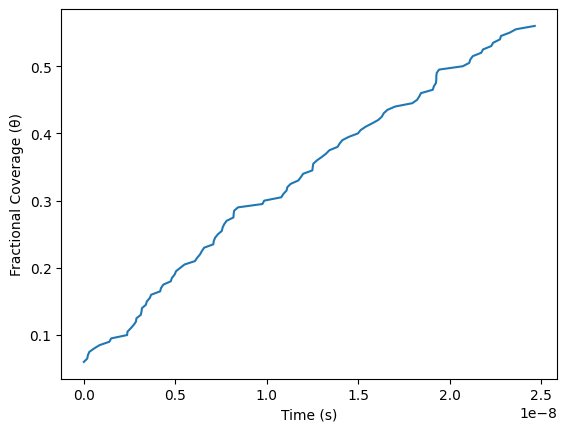

In [34]:
LENGTH = 20
base_Si_layer = initialize_lattice(LENGTH, 1, 0.9) # 0.90 contains 10% vacancies (defects)

# even, layer 2
second_layer = initialize_lattice(LENGTH, 2, 0.05) # Say majority of it is empty

configurations, times, fractional_coverages = run_monolayer_simulation(second_layer, 2, base_Si_layer, LENGTH, n_steps=100, simulation_params=(133, 500))

plt.plot(times, fractional_coverages)
plt.xlabel('Time (s)'), plt.ylabel('Fractional Coverage (θ)')
plt.show()

In [35]:
layer_mask = initialize_lattice(LENGTH, 1)
base_Si_layer[(base_Si_layer == 0) & (layer_mask != 0)] = 2

base_Si_layer[base_Si_layer == 1] = 3
for i, config in enumerate(configurations):
    configurations[i] = np.abs(base_Si_layer - config)

In [36]:
# Create the figure
fig = go.Figure()

# Add traces for the first configuration (initial frame)
fig.add_trace(go.Heatmap(
    z=configurations[0],
    colorscale=[
        [0, 'blue'],     # 0 -> unoccupied on current layer
        [0.33, 'red'],   # 1 -> occupied on current layer
        [0.67, 'green'], # 2 -> unoccupied on previous layer
        [1.0, 'yellow']  # 3 -> occupied on previous layer
    ],
    colorbar= dict(
        title="Legend",  # Title for the legend
        titleside="bottom",
        tickvals=[0, 1, 2, 3],  # Values for the ticks
        ticktext=["unoccupied on current layer", "occupied on current layer", "unoccupied on previous layer", "occupied on previous layer"]  # Labels for the ticks
    ),
    showscale=True,
    zmin=0,
    zmax=3
))

# Define frames for the animation
frames = [
    go.Frame(
        data=[go.Heatmap(
            z=config,
            colorscale=[
                [0, 'blue'],   # 0
                [0.33, 'red'],   # 1
                [0.67, 'green'], # 2
                [1.0, 'yellow']  # 3
            ],
            showscale=True,
            zmin=0,
            zmax=3
        )],
        name=f"Step {step}"
    )
    for step, config in enumerate(configurations)
]

fig.frames = frames

# Add buttons and slider for animation
fig.update_layout(
    title='Adsorption Process Animation',
    xaxis_title='Lattice X',
    yaxis_title='Lattice Y',
    height=600,
    width=800,
    showlegend=True,  # Make sure the legend is shown in every frame
    legend=dict(
        x=1.05,   # Position of legend on x-axis
        y=0.5,    # Position of legend on y-axis
        traceorder='normal',
        font=dict(size=10),  # Adjust font size for smaller legend
        bgcolor='rgba(255, 255, 255, 0)',  # Optional: transparent background
        bordercolor='Black',
        borderwidth=1
    ),
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }],
    sliders=[{
        'active': 0,
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Time Step: ',
            'visible': True,
            'xanchor': 'right'
        },
        'transition': {'duration': 300, 'easing': 'cubic-in-out'},
        'pad': {'b': 10},
        'len': 0.9,
        'x': 0.1,
        'y': 0,
        'steps': [{
            'args': [[f"Step {step}"], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}],
            'label': str(step),
            'method': 'animate'
        } for step in range(len(configurations))]
    }]
)

# Show the figure
fig.show()

In [41]:
LENGTH = 30
layers, times = grow_Si(30, LENGTH, 1, 400) # 370 is a good number

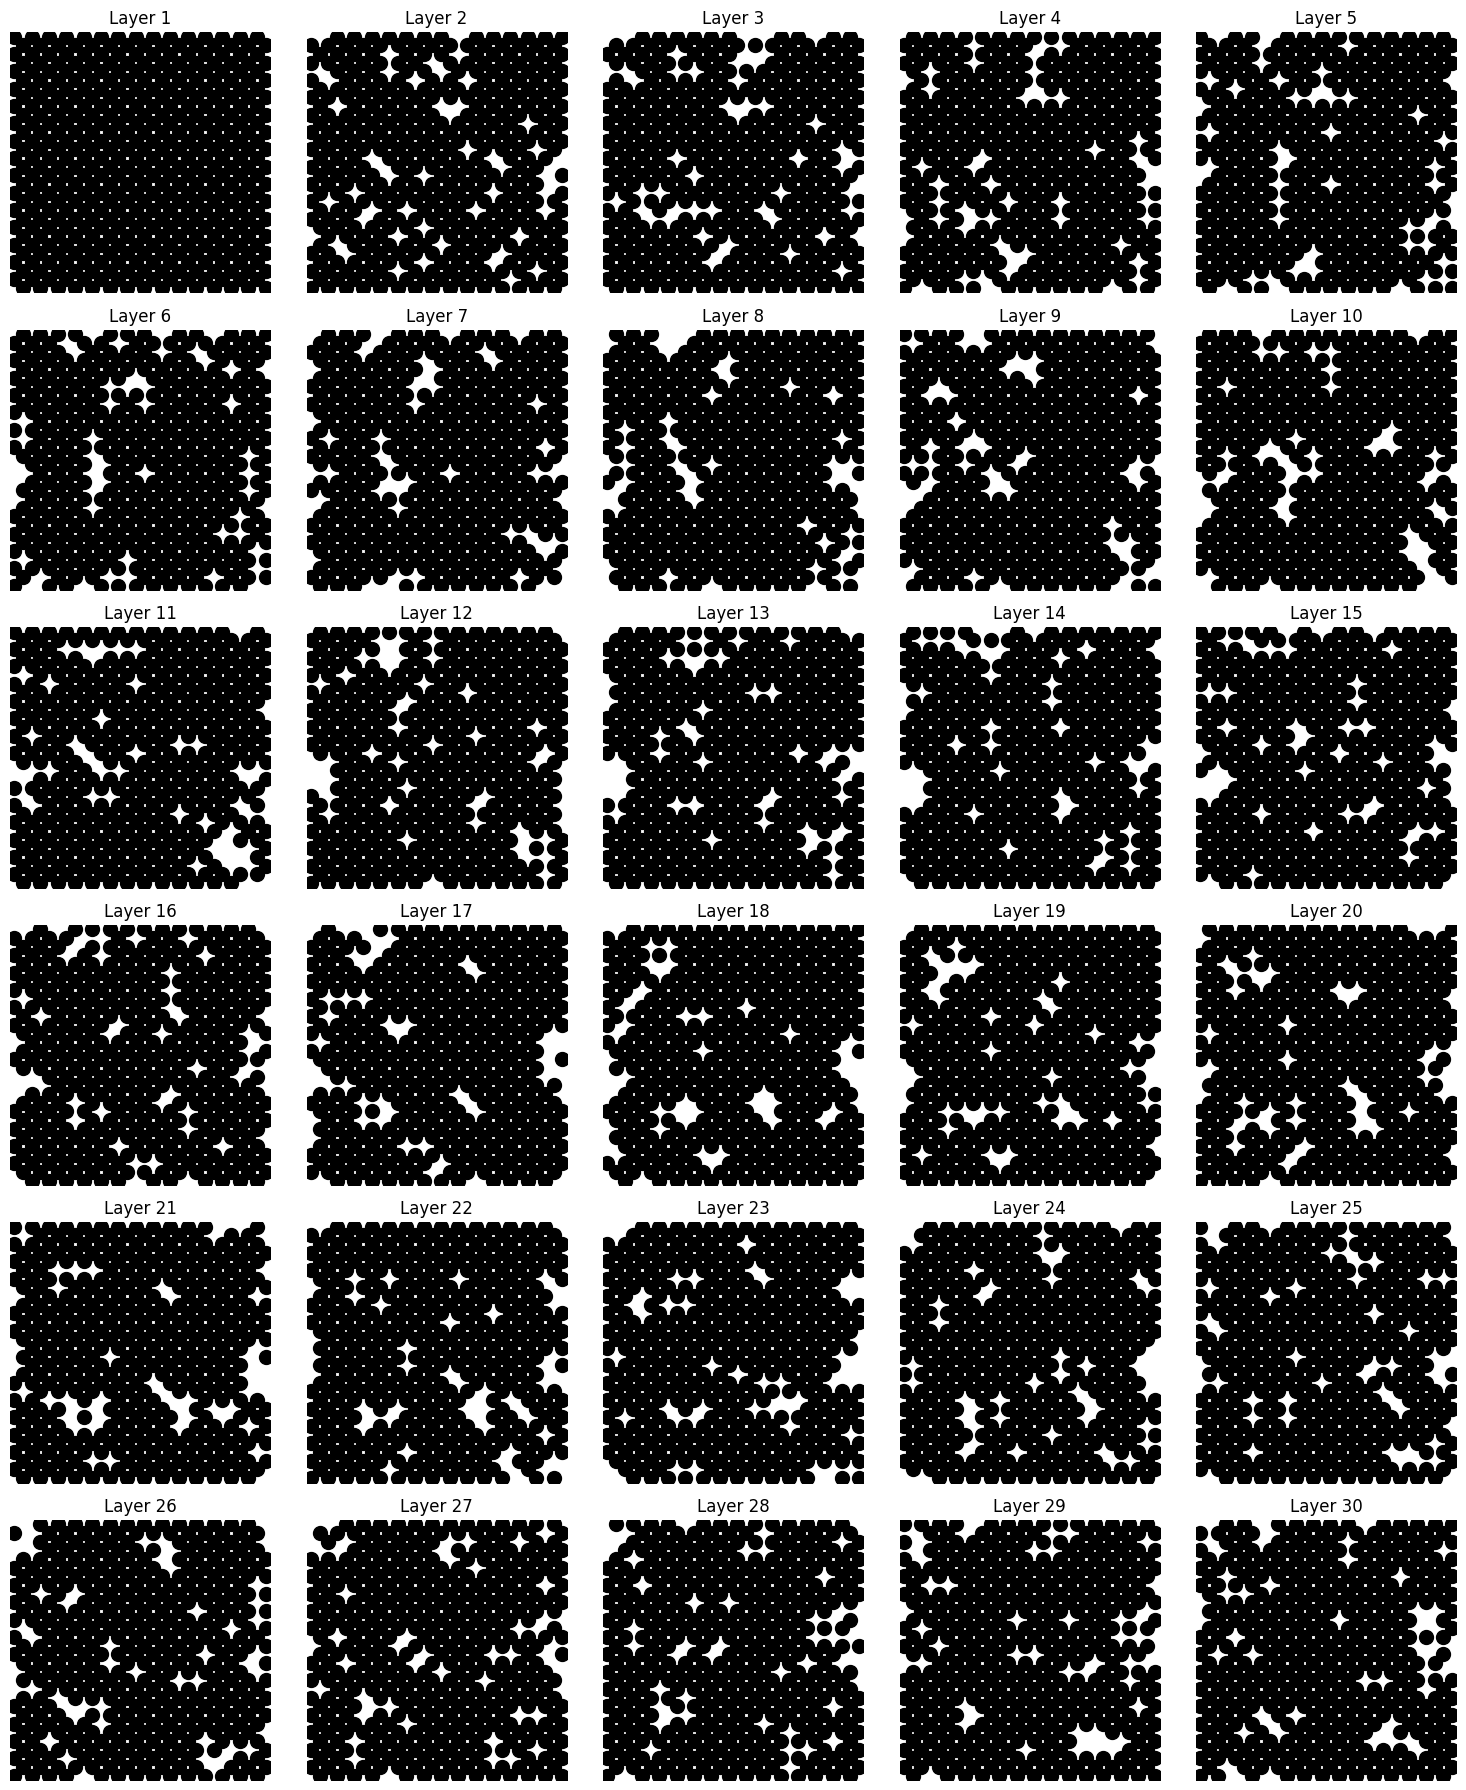

In [42]:
array_list = layers

# Determine number of rows and columns needed
max_columns = 5
num_arrays = len(array_list)
num_rows = (num_arrays // max_columns) + (num_arrays % max_columns > 0)

# Create the subplots
fig, axes = plt.subplots(num_rows, max_columns, figsize=(15, num_rows * 3))

# Flatten axes array for easy iteration, in case we have a 2D grid of subplots
axes = axes.flatten()

# Plot each binary array
for i, array in enumerate(array_list):
    # Get the indices of the 1's in the array
    ones = np.column_stack(np.where(array == 1))
    
    # Scatter plot for the 1's, using dots
    axes[i].scatter(ones[:, 1], ones[:, 0], color='black', s=100, marker='o')
    axes[i].set_title(f"Layer {i+1}")
    axes[i].set_xlim(-0.5, array.shape[1]-0.5)
    axes[i].set_ylim(array.shape[0]-0.5, -0.5)
    axes[i].set_aspect('equal')  # Make sure the grid is square
    axes[i].axis('off')  # Turn off the axis

# Turn off axes for any empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

### Scaling factor of atoms position for Si lattice:
* Distance between neighbours is 0.235 nm diagonally
* Distance in x, y, and z are offset by 1/4 times the lattice constant (where &alpha; / 4 = 0.13575 nm):

<div align="center">

$$
\vec{r}_1 = \frac{\alpha}{4} \vec{x} + \frac{\alpha}{4} \vec{y} + \frac{\alpha}{4} \vec{z}
$$

</div>

* Si radius is 0.132 nm

In [43]:
alpha = 5.43 # A
offset = alpha/4 
radius = 1.32 # A

with open('si_growth2.lammpstrj', 'w') as file:    
    total_layers = len(layers) 
    
    sum_atoms = 0
    atom_id = 1
    atom_data = ''
    bounds = [(0.0, offset * total_layers), (0.0, offset * total_layers), (0.0, offset * total_layers)]

    for z, layer in enumerate(layers):
        file.write('ITEM: TIMESTEP\n')
        file.write(f'{sum(times[0:z+1])}\n')

        sum_atoms += np.sum(layer)
        file.write('ITEM: NUMBER OF ATOMS\n')
        file.write(f'{sum_atoms}\n')

        file.write('ITEM: BOX BOUNDS pp pp pp\n')
        
        for bound in bounds:
            file.write(f'{bound[0]} {bound[1]}\n')

        file.write('ITEM: ATOMS id type x y z\n')
        if atom_data:
            file.write(atom_data)

        for x in range(LENGTH):
            for y in range(LENGTH):
                if layer[x,y]:

                    info = (atom_id, 1, (x * offset), (y * offset), (z * offset))
                    info_str = ' '.join(map(str, info)) + '\n'
                    atom_data += info_str
                    file.write(info_str)
                    atom_id += 1

with open('silicon2.data', 'w') as file:
    file.write('# Header \n')
    file.write(f'{sum_atoms} atoms\n\n')
    file.write('   1 atom types\n\n')
    
    bounds = [(0.0, total_layers * offset, 'xlo xhi'), (0.0, total_layers * offset, 'ylo yhi'), (0.0, total_layers * offset, 'zlo zhi')]

    for bound in bounds:
        file.write(f'{bound[0]} {bound[1]} {bound[2]}\n')

    file.write('0.000000 0.000000 0.000000 xy xz yz\n\n')

    file.write('Masses\n\n1 28.0855\n\n')
    
    file.write('Atoms\n\n')
    file.write(atom_data) 

    file.write('\n')